## MultiClass Classifier for Fashion MNIST dataset

The notebook is a run through of the calssifier code.
All the steps and considerations are also noted here.


In [67]:
## Import Libraries in this block ##
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf


from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model
from keras.utils import plot_model
from keras.utils import to_categorical
import numpy as np
import os

from keras.applications import ResNet50 ## Needed for pretrained network
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as scorer
import matplotlib.pyplot as plt


In [68]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [84]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
customized_path = 'DeepLearning'
sys_path = os.path.join(prefix, customized_path)
sys.path.append(sys_path)
%cd /content/gdrive/MyDrive/DeepLearning
!ls

/content/gdrive/MyDrive/DeepLearning
autoencoder.png			features_train.pkl
AUTOENCODER.png			ImageCap_Data
best_model_c100.h5		MidTerm
best_model_c10.h5		model_inceptionv3.png
best_resnet_model_c100.h5	model_inceptionv.png
best_resnet_model_c10.h5	model.png
best_tf_resnet50_model_c100.h5	MR_CNN_model.h5
best_tf_resnet50_model_c10.h5	MultiresCNN-network.png
c10_resnet20_model.103.h5	PaaperPresentation.gslides
cat.png				resnet.png
cnn-y-network.png		sample_data
descriptions_test.txt		saved_images
descriptions.txt		saved_models
divercity_models		saved_models_mrc
fashion_mnist_classifier.py	saved_models_mt
features_test_Inception.pkl	VC_CNN_model.h5
features_test.pkl		VGG_CNN_model.h5
features_train_Inception.pkl


## Design Considerations and Code
The code blocks of interest start from here.

The coe is broken into funtions to perform different aspects of the process.
First , the Load_Dataset function i used to load the data from keras api and normalize the values. 

In [70]:
## Funtion to load and normalize data ##

def Load_Datset(dataset):
  if dataset == "fashion_mnist":
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

  x_train = x_train.astype('float32') / 255
  x_test = x_test.astype('float32') / 255

  print("Train Data shape for {}:{}{}".format(dataset,x_train.shape, y_train.shape))
  print("Test Data shape for {}:{}{}".format(dataset,x_test.shape, y_test.shape))

  return x_train, x_test,y_train,y_test

## The Model

I have used a custom implementation of Resnet20 architecture for this task.
From my experience of wokring with multiclass calssification the following consideration were made to choose the model.


1.   A Basic CNN model with few CNN layers will be able to perform the task however achieving high accuracy requires the use of a deep architecture that can extract high level features that can genralize well to the test set.
2.   Resnet uses skip level connections to retain information from earlier layers while extracting higher level features at the deeper levels, this makes it a rather effective architeture for object calssification using images.

The code block below uses the Keras funtional API to build the required architeture which is shows in a lter section.



In [74]:
## Funtion to build Resnet ##
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def Resnet_v1(input_shape, depth, num_classes):

    # Start model definition.
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    #x = AveragePooling(pool_size=8)(x)
    y = Flatten()(x)
    x = AveragePooling2D(pool_size=4)(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



## Data Preparation

To feed fashion MNIST images to Resnet architeture we need the vectors be 4 dimensional, as we can see fashion MNISt grayscale images of 28,28 dims. This gives us a (samples,28,28) vector. Here it is reshaped to (samples,28,28,1).

I have also used a 80/20 split the on trains set to obtain a train and validation set.This way the test set is only used to evaluate the model.  

In [75]:
#Load dataset
x_train, x_test,y_train,y_test = Load_Datset("fashion_mnist")
input_shape = ( x_train.shape[1], x_train.shape[2],1)

# Save labels before encoding to display images,labels
x=x_train
y = y_train

# From sparse label to categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("Number of unique classes:",num_labels)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=1)
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_train.shape[1], x_train.shape[2],1)
x_val = x_val.reshape(x_val.shape[0],x_train.shape[1], x_train.shape[2],1)

print("Data Reshaped for Resnet")
print(x_train.shape,x_val.shape,x_test.shape)


Train Data shape for fashion_mnist:(60000, 28, 28)(60000,)
Test Data shape for fashion_mnist:(10000, 28, 28)(10000,)
Number of unique classes: 10
Data Reshaped for Resnet
(48000, 28, 28, 1) (12000, 28, 28, 1) (10000, 28, 28, 1)


A few examples from the dataset are vizualized here.

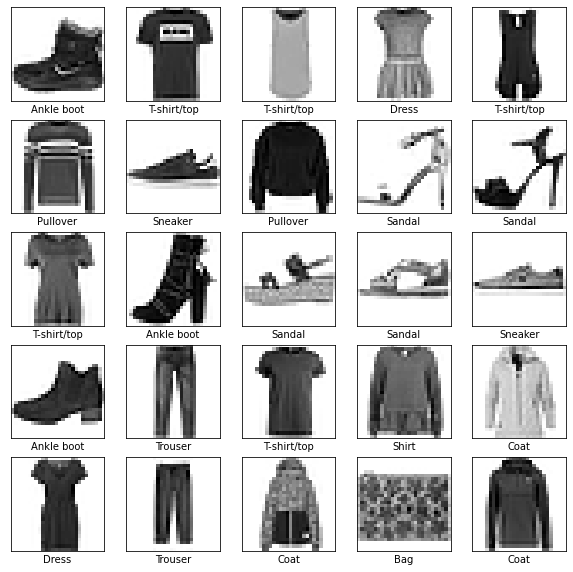

In [76]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
              
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y[i]])
plt.show()

## Learning Rate 

A very important consideration while training any deep network is the learning rate. Here is use a custom lr scheduler as shown. The Lr schedule used is based on the number of epochs to best optimize the network and find the best minima possible as network converges. The idea is to reduce the learning rate in stages as the epochs increase since this will reduce the oscillation and provide better optimization of weights.  

In [71]:
##Learning Rate Schedule ##
def lr_schedule(epoch):

    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

# Data Augmentation , Training and Testing

The function in the below code block ,compiles the model architecture returned by Resnet_v1 function and trains the network.

## Data Augmentation

Again, from experience I can state the following observations:


1.   Augmenting the data helps ensure that the network doesnt memeorize the training data.
2.   Further, it allows us to introduce tranlation, rotational invariance to the obtained features as we radomly rotate and translate images.
3.  Here I tried training with different kinds of augmentation and settle with rotation,slight translation and flipping (horizotal and vertical)


I have written checkpoints to save the learned model at every 20 epochs.
In addition to a Lr schedule , I also use Lr reduction to reduce the Learning rate  if the validation accuracy plateaus

In [72]:
def Train_Test_Plot(model, x_train,y_train,x_val,y_val,x_test,y_test, optimizer,epochs,batch_size):

  # Compile model
  model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
  
  # prepare model model saving directory.
  save_dir = os.path.join(os.getcwd(), 'divercity_models')
  model_name = 'resnet20_model.{epoch:03d}.h5' 
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  filepath = os.path.join(save_dir, model_name)

  # prepare callbacks for model saving and for learning rate adjustment. 
  steps_per_epoch=len(x_train)//batch_size
  save_period = 20
  checkpoint = ModelCheckpoint(filepath=filepath,
                               monitor='val_acc',
                               verbose=1,
                               save_freq=int(steps_per_epoch*save_period))

  lr_scheduler = LearningRateScheduler(lr_schedule)

  lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

  callbacks = [checkpoint, lr_reducer, lr_scheduler]
  
  #augmented data
  datagen = ImageDataGenerator(
      # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=20,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=True
      )
  datagen.fit(x_train)
  # Train the model 
  history= model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_val,y_val),
                        epochs=epochs, verbose=1, workers=4,
                        steps_per_epoch=len(x_train)//batch_size,
                        callbacks=callbacks)
 

  # Evaluate Model on Test set
  score = model.evaluate(x_test,
                       y_test,
                       batch_size=batch_size,
                       verbose=2)
  print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))
  
  #Plot training curve
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

# Evaluation and Reporting 

while I test the accuracy on the test set immediately after training in the above funtion, the confusion matrix and precision,recall and F-score are calculated by the clock below.

In [73]:
def Evaluate_Pred(model,x_test,y_test):

  y_pred = model.predict(x_test)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(y_test, axis=1)
  cm = confusion_matrix(y_test,y_pred)
  scores= scorer(y_test,y_pred)

  return cm, scores


#Execution
 The code blocks from here on call the appropriate funtions to execute the idea suggested above and print the results.

I have printed the model summary here to view individual layers and the vector sizes from input to output.

In [77]:
## Network parameters
batch_size = 1024
n_filters =16
## No of residual blocks(depth=20 => n=3) ##
n=3
## d = 6n+2 ##
depth = n*6+2

model=Resnet_v1(input_shape,depth,num_labels)

# verify the model using graph
# enable this if pydot can be installed
#!pip install pydot
#plot_model(model, to_file='resnet.png', show_shapes=True)
model.summary()



Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 28, 28, 16)   160         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 28, 28, 16)   64          conv2d_105[0][0]                 
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 28, 28, 16)   0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

This below section sets the number of epochs , optimizer and calls the training funtion

Epoch 1/200
46/46 [==============================] - 30s 561ms/step - loss: 3.4863 - accuracy: 0.3362 - val_loss: 7.1516 - val_accuracy: 0.2020
Epoch 2/200
46/46 [==============================] - 26s 540ms/step - loss: 1.0966 - accuracy: 0.6605 - val_loss: 1.4523 - val_accuracy: 0.5588
Epoch 3/200
46/46 [==============================] - 26s 538ms/step - loss: 0.9187 - accuracy: 0.7198 - val_loss: 1.2073 - val_accuracy: 0.6038
Epoch 4/200
46/46 [==============================] - 26s 541ms/step - loss: 0.8490 - accuracy: 0.7439 - val_loss: 0.9656 - val_accuracy: 0.7011
Epoch 5/200
46/46 [==============================] - 26s 536ms/step - loss: 0.7846 - accuracy: 0.7658 - val_loss: 0.8238 - val_accuracy: 0.7436
Epoch 6/200
46/46 [==============================] - 26s 540ms/step - loss: 0.7411 - accuracy: 0.7834 - val_loss: 0.7896 - val_accuracy: 0.7683
Epoch 7/200
46/46 [==============================] - 26s 536ms/step - loss: 0.7012 - accuracy: 0.7982 - val_loss: 0.7659 - val_accuracy:

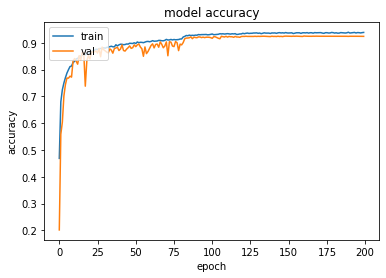

In [78]:
## Training parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 200

Train_Test_Plot(model, x_train, y_train, x_val, y_val, x_test, y_test, optimizer, epochs, batch_size)



##Results

As we can see the model achives nearly 92% test accuracy with high precision for most classes . It is worth noting however that class 7 (Sandal) appears to have very low precison which is seen in the consuion matric as well.

I have also reported F- score which is given as 
F-score = (precision*recall)/(precision+recall) 

In [79]:
con_mat, scores = Evaluate_Pred(model,x_test,y_test)

print("Confusion matrix")
print(con_mat)
print("precision for each class:\n",scores[0])
print("Recall for each class:\n",scores[1])
print("F score for each class:\n",scores[2])

Confusion matrix
[[836   3  12  20   4   1 118   0   6   0]
 [  0 986   0  10   1   0   2   0   1   0]
 [ 17   1 876   9  41   0  56   0   0   0]
 [ 17   7  10 922  16   1  27   0   0   0]
 [  1   2  31  30 887   0  45   0   4   0]
 [  0   0   0   0   0 990   0   7   0   3]
 [ 73   1  46  21  78   0 774   0   7   0]
 [  0   0   0   0   0  15   0 966   1  18]
 [  0   2   1   4   1   1   2   1 988   0]
 [  0   1   0   1   0  10   0  30   1 957]]
precision for each class:
 [0.88559322 0.98305085 0.89754098 0.906588   0.86284047 0.97249509
 0.75585938 0.96215139 0.98015873 0.97852761]
Recall for each class:
 [0.836 0.986 0.876 0.922 0.887 0.99  0.774 0.966 0.988 0.957]
F score for each class:
 [0.8600823  0.98452322 0.88663968 0.91422905 0.87475345 0.98116947
 0.76482213 0.96407186 0.98406375 0.96764408]


In [83]:
## This section is to test pretrained models and report metrics
##%cd divercity_models
model_loaded = tf.keras.models.load_model('resnet20_model.180.h5')
#new_model.summary()
loss, acc = model_loaded.evaluate(x_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
con_mat, scores = Evaluate_Pred(model_loaded,x_test,y_test)

print("Confusion matrix")
print(con_mat)
print("precision for each class:\n",scores[0])
print("Recall for each class:\n",scores[1])
print("F score for each class:\n",scores[2])

[Errno 2] No such file or directory: 'divercity_models'
/content/gdrive/My Drive/DeepLearning/divercity_models
313/313 - 2s - loss: 0.3210 - accuracy: 0.9184
Restored model, accuracy: 91.84%
Confusion matrix
[[836   3  12  19   4   1 119   0   6   0]
 [  0 986   0  10   1   0   2   0   1   0]
 [ 16   1 877   9  41   0  56   0   0   0]
 [ 17   7  10 921  17   1  27   0   0   0]
 [  1   2  31  30 887   0  45   0   4   0]
 [  0   0   0   0   0 990   0   7   0   3]
 [ 73   1  46  20  78   0 775   0   7   0]
 [  0   0   0   0   0  15   0 967   1  17]
 [  0   2   1   4   1   1   2   1 988   0]
 [  0   1   0   1   0  10   0  30   1 957]]
precision for each class:
 [0.88653234 0.98305085 0.89764585 0.90828402 0.86200194 0.97249509
 0.75536062 0.96218905 0.98015873 0.97952917]
Recall for each class:
 [0.836 0.986 0.877 0.921 0.887 0.99  0.775 0.967 0.988 0.957]
F score for each class:
 [0.86052496 0.98452322 0.88720283 0.91459782 0.87432233 0.98116947
 0.76505429 0.96458853 0.98406375 0.9681335